# Week 9: VAEP (Valuing Actions by Estimating Probabilities) 구현

본 노트북은 StatsBomb 공개 이벤트 데이터를 사용하여 VAEP 프레임워크를 구현하는 과정을 다룹니다.

**VAEP 프레임워크 개요:**
1.  축구 경기 데이터를 **ATOMIC SPADL** (Soccer Player Action Description Language) 포맷으로 변환합니다.
2.  각 액션(action)이 득점(score) 또는 실점(concede)으로 이어질 확률을 예측하는 두 개의 머신러닝 모델(XGBoost 사용)을 훈련시킵니다.
3.  두 모델의 예측값을 사용하여 각 액션의 가치(ATOMIC VAEP 값)를 계산합니다.
4.  계산된 ATOMIC VAEP 값을 바탕으로 선수 및 액션을 평가하고 시각화합니다.

In [ ]:
!git clone https://github.com/narame7/UOS-FootballDataAnalytics-Tutorial

In [ ]:
%cd 'UOS-FootballDataAnalytics-Tutorial/Week 9'

In [ ]:
!pip install pandera==0.13.4 scipy==1.11.4 statsbombpy torchmetrics

In [ ]:
import warnings
import pandas as pd

pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import (
    precision_score,
    recall_score,
    brier_score_loss,
    roc_auc_score,
    log_loss,
    f1_score,
)
from sklearn.model_selection import train_test_split
import xgboost
import torch
from torchmetrics.classification import BinaryCalibrationError
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import matplotsoccer as mps  # 축구 이벤트 데이터 시각화
from socceraction.data.statsbomb import StatsBombLoader  # StatsBomb 데이터 로더

import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab
import socceraction.atomic.vaep.formula as vaepformula

### Set up the StatsBombLoader

In [7]:
# StatsBomb 데이터 로더 객체를 생성합니다. 무료 공개 데이터 접근을 위해 creds를 None으로 설정합니다.
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})
SBL

In [8]:
# 사용 가능한 대회 목록
competitions = SBL.competitions()
competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
0,281,9,1. Bundesliga,Germany,male,2023/2024
1,27,9,1. Bundesliga,Germany,male,2015/2016
2,107,1267,African Cup of Nations,Africa,male,2023
3,4,16,Champions League,Europe,male,2018/2019
4,1,16,Champions League,Europe,male,2017/2018
...,...,...,...,...,...,...
70,75,35,UEFA Europa League,Europe,male,1988/1989
71,315,53,UEFA Women's Euro,Europe,female,2025
72,106,53,UEFA Women's Euro,Europe,female,2022
73,107,72,Women's World Cup,International,female,2023


In [9]:
train_competitions = competitions[
	(competitions.competition_name.isin(["Premier League", "La Liga", "Serie A", "1. Bundesliga", "Ligue 1"])) &
	(competitions.season_name >= "2020/2021")
].reset_index(drop=True)

train_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
0,281,9,1. Bundesliga,Germany,male,2023/2024
1,90,11,La Liga,Spain,male,2020/2021
2,235,7,Ligue 1,France,male,2022/2023
3,108,7,Ligue 1,France,male,2021/2022


In [10]:
# 'FIFA World Cup' 2018 시즌
test_competitions = competitions[
	(competitions.competition_name == "FIFA World Cup")
	& (competitions.season_name == "2018")
]
test_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
30,3,43,FIFA World Cup,International,male,2018


In [11]:
train_games = pd.concat([
	SBL.games(row.competition_id, row.season_id)
	for row in train_competitions.itertuples()
]).reset_index(drop=True)

train_games

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3895302,281,9,Regular Season,29,2024-04-14 17:30:00,904,176,5,0,BayArena,Harm Osmers
1,3895292,281,9,Regular Season,28,2024-04-06 15:30:00,190,904,0,1,Stadion An der Alten Försterei,Benjamin Brand
2,3895333,281,9,Regular Season,32,2024-05-05 18:30:00,184,904,1,5,Deutsche Bank Park,Christian Dingert
3,3895340,281,9,Regular Season,33,2024-05-12 20:30:00,868,904,0,5,Vonovia Ruhrstadion,Benjamin Brand
4,3895348,281,9,Regular Season,34,2024-05-18 16:30:00,904,172,2,1,BayArena,Matthias Jöllenbeck
...,...,...,...,...,...,...,...,...,...,...,...,...
122,3802948,108,7,Regular Season,38,2022-05-21 21:00:00,131,141,5,0,Parc des Princes,Antony Gautier
123,3802930,108,7,Regular Season,36,2022-05-08 20:45:00,131,133,2,2,Parc des Princes,Jérôme Brisard
124,3802793,108,7,Regular Season,16,2021-12-01 22:05:00,131,136,0,0,Parc des Princes,Clément Turpin
125,3802839,108,7,Regular Season,25,2022-02-19 22:00:00,144,131,3,1,Stade de la Beaujoire - Louis Fonteneau,Mikael Lesage


In [12]:
test_games = pd.concat([
	SBL.games(row.competition_id, row.season_id)
	for row in test_competitions.itertuples()
]).reset_index(drop=True)

test_games

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,7585,3,43,Round of 16,4,2018-07-03 20:00:00,769,768,1,1,Otkritie Bank Arena,Mark Geiger
1,7570,3,43,Group Stage,3,2018-06-28 20:00:00,768,782,0,1,Stadion Kaliningrad,Damir Skomina
2,7586,3,43,Round of 16,4,2018-07-03 16:00:00,790,773,1,0,Saint-Petersburg Stadium,Damir Skomina
3,7557,3,43,Group Stage,3,2018-06-25 20:00:00,797,780,1,1,Mordovia Arena,Enrique Cáceres
4,7542,3,43,Group Stage,2,2018-06-20 14:00:00,780,788,1,0,Stadion Luzhniki,Mark Geiger
...,...,...,...,...,...,...,...,...,...,...,...,...
59,7540,3,43,Group Stage,2,2018-06-19 20:00:00,796,774,3,1,Saint-Petersburg Stadium,Enrique Cáceres
60,8652,3,43,Quarter-finals,5,2018-07-07 20:00:00,796,785,2,2,\tOlimpiyskiy Stadion Fisht,Sandro Ricci
61,7563,3,43,Group Stage,3,2018-06-26 16:00:00,776,771,0,0,Stadion Luzhniki,Sandro Ricci
62,7556,3,43,Group Stage,2,2018-06-24 17:00:00,778,787,2,2,\tEkaterinburg Arena,Gianluca Rocchi


### 🥅 ATOMIC SPADL (Soccer Player Action Description Language) 전처리 및 로딩

- ATOMIC SPADL: 기존 SPADL의 확장판으로, 선수의 액션을 "원자적인(atomic)" 단위로 분해하여 표현하는 데이터 포맷입니다.
- [blog](https://dtai.cs.kuleuven.be/sports/blog/introducing-atomic-spadl-a-new-way-to-represent-event-stream-data/)
- [Github](https://github.com/ML-KULeuven/socceraction/tree/master/socceraction/atomic)

### ATOMIC VAEP 특징(Feature) 및 레이블(Label) 함수 정의

- Features: 현재 액션 및 이전 액션들의 유형, 위치, 시간 등
- Labels: 해당 액션 이후 정해진 시간 내에 득점(scores)이 발생했는지, 실점(concedes)이 발생했는지 여부

In [13]:
xfns = [
	fs.actiontype,
	fs.actiontype_onehot,
	fs.bodypart,
	fs.bodypart_onehot,
	fs.goalscore,
	fs.location,
	fs.polar,
	fs.direction,
	fs.team,
	fs.time,
	fs.time_delta
]

def compute_features(actions, home_team_id, nb_prev_actions=3):
	gamestates = fs.gamestates(atomicspadl.add_names(actions), nb_prev_actions)
	gamestates = fs.play_left_to_right(gamestates, home_team_id)

	df_features = pd.concat([fn(gamestates) for fn in xfns], axis=1)
	return df_features

In [14]:
yfns = [
	lab.scores, 
	lab.concedes
]

def compute_labels(actions):
	df_labels = pd.concat([fn(atomicspadl.add_names(actions)) for fn in yfns], axis=1)
	return df_labels

In [15]:
def get_dataset(games):
	X_list, Y_list = [], []

	for game in tqdm(list(games.itertuples()), desc="Games processed"):
		# load data
		events = SBL.events(game.game_id)

		# StatsBomb 이벤트 데이터를 SPADL 액션 데이터로 변환합니다.
		actions = spadl.statsbomb.convert_to_actions(
				events,
				home_team_id=game.home_team_id,
				xy_fidelity_version=1,
				shot_fidelity_version=1
		)
		actions = atomicspadl.convert_to_atomic(actions)
		
		X_list.append(compute_features(actions, home_team_id=game.home_team_id))
		Y_list.append(compute_labels(actions))	

	X = pd.concat(X_list, axis=0).reset_index(drop=True)
	Y = pd.concat(Y_list, axis=0).reset_index(drop=True)
	
	return X, Y

In [16]:
X_train, Y_train = get_dataset(train_games)
X_test, Y_test = get_dataset(test_games)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

Games processed:   0%|          | 0/127 [00:00<?, ?it/s]

Games processed:   0%|          | 0/64 [00:00<?, ?it/s]

((401791, 148),
 (401791, 2),
 (44644, 148),
 (44644, 2),
 (192711, 148),
 (192711, 2))

In [17]:
X_train

,actiontype_a0,actiontype_a1,actiontype_a2,actiontype_pass_a0,actiontype_cross_a0,actiontype_throw_in_a0,actiontype_freekick_crossed_a0,actiontype_freekick_short_a0,actiontype_corner_crossed_a0,actiontype_corner_short_a0,actiontype_take_on_a0,actiontype_foul_a0,actiontype_tackle_a0,actiontype_interception_a0,actiontype_shot_a0,actiontype_shot_penalty_a0,actiontype_shot_freekick_a0,actiontype_keeper_save_a0,actiontype_keeper_claim_a0,actiontype_keeper_punch_a0,actiontype_keeper_pick_up_a0,actiontype_clearance_a0,actiontype_bad_touch_a0,actiontype_non_action_a0,actiontype_dribble_a0,actiontype_goalkick_a0,actiontype_receival_a0,actiontype_out_a0,actiontype_offside_a0,actiontype_goal_a0,actiontype_owngoal_a0,actiontype_yellow_card_a0,actiontype_red_card_a0,actiontype_corner_a0,actiontype_freekick_a0,actiontype_pass_a1,actiontype_cross_a1,actiontype_throw_in_a1,actiontype_freekick_crossed_a1,actiontype_freekick_short_a1,actiontype_corner_crossed_a1,actiontype_corner_short_a1,actiontype_take_on_a1,actiontype_foul_a1,actiontype_tackle_a1,actiontype_interception_a1,actiontype_shot_a1,actiontype_shot_penalty_a1,actiontype_shot_freekick_a1,actiontype_keeper_save_a1,actiontype_keeper_claim_a1,actiontype_keeper_punch_a1,actiontype_keeper_pick_up_a1,actiontype_clearance_a1,actiontype_bad_touch_a1,actiontype_non_action_a1,actiontype_dribble_a1,actiontype_goalkick_a1,actiontype_receival_a1,actiontype_out_a1,actiontype_offside_a1,actiontype_goal_a1,actiontype_owngoal_a1,actiontype_yellow_card_a1,actiontype_red_card_a1,actiontype_corner_a1,actiontype_freekick_a1,actiontype_pass_a2,actiontype_cross_a2,actiontype_throw_in_a2,actiontype_freekick_crossed_a2,actiontype_freekick_short_a2,actiontype_corner_crossed_a2,actiontype_corner_short_a2,actiontype_take_on_a2,actiontype_foul_a2,actiontype_tackle_a2,actiontype_interception_a2,actiontype_shot_a2,actiontype_shot_penalty_a2,actiontype_shot_freekick_a2,actiontype_keeper_save_a2,actiontype_keeper_claim_a2,actiontype_keeper_punch_a2,actiontype_keeper_pick_up_a2,actiontype_clearance_a2,actiontype_bad_touch_a2,actiontype_non_action_a2,actiontype_dribble_a2,actiontype_goalkick_a2,actiontype_receival_a2,actiontype_out_a2,actiontype_offside_a2,actiontype_goal_a2,actiontype_owngoal_a2,actiontype_yellow_card_a2,actiontype_red_card_a2,actiontype_corner_a2,actiontype_freekick_a2,bodypart_a0,bodypart_a1,bodypart_a2,bodypart_foot_a0,bodypart_head_a0,bodypart_other_a0,bodypart_head/other_a0,bodypart_foot_a1,bodypart_head_a1,bodypart_other_a1,bodypart_head/other_a1,bodypart_foot_a2,bodypart_head_a2,bodypart_other_a2,bodypart_head/other_a2,goalscore_team,goalscore_opponent,goalscore_diff,x_a0,y_a0,x_a1,y_a1,x_a2,y_a2,dist_to_goal_a0,angle_to_goal_a0,dist_to_goal_a1,angle_to_goal_a1,dist_to_goal_a2,angle_to_goal_a2,dx_a0,dy_a0,dx_a1,dy_a1,dx_a2,dy_a2,team_1,team_2,period_id_a0,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
63352,pass,dribble,receival,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,foot,foot,foot,True,False,False,False,True,False,False,False,True,False,False,False,1,2,-1,79.9750,21.845,85.3125,16.4900,85.3125,16.490,27.820759,0.452154,26.347633,0.726926,26.347633,0.726926,-0.125218,0.992129,-0.705949,0.708263,0.000000,0.000000,True,True,2,2637.0400,5337.0400,2.0,2632.90900,5332.90900,2.0,2632.3280,5332.3280,4.13100,4.7120
427294,cross,dribble,take_on,False,True,

In [18]:
Y_train

,scores,concedes
63352,False,False
427294,False,False
67001,False,False
1318,False,False
145025,False,False
...,...,...
259178,False,False
365838,False,False
131932,False,False
146867,False,False


In [19]:
# scoring 및 conceding 라벨의 분포 확인
# 두 태스크는 독립적으로 다루므로 동시에 True인 경우도 존재함
Y_train[['scores', 'concedes']].value_counts()

scores  concedes
False   False       397955
True    False         3427
False   True           409
dtype: int64

### ATOMIC VAEP 모델 훈련 (Scores & Concedes)
- ATOMIC VAEP 값을 계산하기 위해 두 개의 개별적인 분류 모델을 훈련.

In [20]:
xgboost_params = {
	"n_estimators": 50,
	"max_depth": 3,
	"n_jobs": -3,
	"verbosity": 1,
	"tree_method": "hist",
	"enable_categorical": True
}

Y_hat = pd.DataFrame()
models = {}
for col in tqdm(["scores", "concedes"], desc="Models trained"):
	model = xgboost.XGBClassifier(**xgboost_params)
	model.fit(X_train, Y_train[col], eval_set=[(X_valid, Y_valid[col])])
	models[col] = model

Models trained:   0%|          | 0/2 [00:00<?, ?it/s]

[0]	validation_0-logloss:0.44485
[1]	validation_0-logloss:0.30814
[2]	validation_0-logloss:0.22253
[3]	validation_0-logloss:0.16575
[4]	validation_0-logloss:0.12680
[5]	validation_0-logloss:0.09966
[6]	validation_0-logloss:0.08057
[7]	validation_0-logloss:0.06708
[8]	validation_0-logloss:0.05753
[9]	validation_0-logloss:0.05071
[10]	validation_0-logloss:0.04589
[11]	validation_0-logloss:0.04253
[12]	validation_0-logloss:0.04016
[13]	validation_0-logloss:0.03851
[14]	validation_0-logloss:0.03736
[15]	validation_0-logloss:0.03652
[16]	validation_0-logloss:0.03593
[17]	validation_0-logloss:0.03547
[18]	validation_0-logloss:0.03518
[19]	validation_0-logloss:0.03491
[20]	validation_0-logloss:0.03473
[21]	validation_0-logloss:0.03461
[22]	validation_0-logloss:0.03455
[23]	validation_0-logloss:0.03449
[24]	validation_0-logloss:0.03439
[25]	validation_0-logloss:0.03416
[26]	validation_0-logloss:0.03409
[27]	validation_0-logloss:0.03407
[28]	validation_0-logloss:0.03401
[29]	validation_0-loglos

In [21]:
def evaluate(y, y_hat):
	bce_l1 = BinaryCalibrationError(n_bins=10, norm="l1")

	return {
		"precision": precision_score(y, y_hat > 0.5),
		"recall": recall_score(y, y_hat > 0.5),
		"f1": f1_score(y, y_hat > 0.5),
		"log_loss": log_loss(y, y_hat),
		"brier_score": brier_score_loss(y, y_hat),
		"auc": roc_auc_score(y, y_hat),
		"ece": bce_l1(torch.Tensor(y_hat.to_numpy()), torch.Tensor(y.to_numpy())).item(),
	}

for col in ["scores", "concedes"]:
	Y_hat[col] = [p[1] for p in models[col].predict_proba(X_test)]
	print(f"\n### {col} ###")
	metrics = evaluate(Y_test[col], Y_hat[col])
	
	for metric , value in metrics.items():
		print(f"{metric}: {value:.4f}")


### scores ###
precision: 0.8968
recall: 0.1671
f1: 0.2817
log_loss: 0.0317
brier_score: 0.0063
auc: 0.8898
ece: 0.0007

### concedes ###
precision: 0.9630
recall: 0.0760
f1: 0.1409
log_loss: 0.0104
brier_score: 0.0016
auc: 0.8322
ece: 0.0007


In [22]:
Y_hat

,scores,concedes
0,0.000619,0.000092
1,0.001158,0.000067
2,0.001686,0.000036
3,0.003574,0.000031
4,0.001742,0.000049
...,...,...
192706,0.053697,0.000152
192707,0.125788,0.000094
192708,0.177483,0.000257
192709,0.979983,0.000350


### ATOMIC VAEP 값 계산
- 모든 액션에 대해 훈련된 모델을 적용하여 'scores' 확률과 'concedes' 확률을 예측한 뒤, 각 액션의 ATOMIC VAEP(Valuing Actions by Estimating Probabilities) 값을 계산합니다.

* Offensive Value (공격 가치): (액션 후 득점 확률) - (액션 전 득점 확률)
* Defensive Value (수비 가치): (액션 후 실점 확률) - (액션 전 실점 확률)
* ATOMIC VAEP Value: (Offensive Value) + (-Defensive Value)

In [23]:
games_verbose = tqdm(list(test_games.itertuples()), desc="Loading game data")
df_teams, df_players, df_actions = [], [], []

for game in games_verbose:
	# load data
	df_teams.append(SBL.teams(game.game_id))
	df_players.append(SBL.players(game.game_id))
	events = SBL.events(game.game_id)

	# StatsBomb 이벤트 데이터를 SPADL 액션 데이터로 변환합니다.
	actions = spadl.statsbomb.convert_to_actions(
			events,
			home_team_id=game.home_team_id,
			xy_fidelity_version=1,
			shot_fidelity_version=1
	)
	actions = atomicspadl.convert_to_atomic(actions)
	df_actions.append(actions)

df_teams = pd.concat(df_teams).drop_duplicates(subset="team_id")
df_player_games = pd.concat(df_players).reset_index(drop=True) # 경기 별 선수 정보. 경기 별 선수 정보 (position, minutes_played)은 다름)
df_players = pd.concat(df_players).drop_duplicates(subset="player_id") # 선수 정보. 선수 정보 (name, nationality 등)은 동일)
df_actions = pd.concat(df_actions).reset_index(drop=True)
df_actions = pd.concat([df_actions, Y_hat], axis=1)
df_actions.head()

Loading game data:   0%|          | 0/64 [00:00<?, ?it/s]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,scores,concedes
0,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,0,1,0.24,769,3445.0,52.0625,34.425,-8.750,-0.85,0,4,0.000619,0.000092
1,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,1,1,0.36,769,5692.0,43.3125,33.575,0.000,0.00,23,0,0.001158,0.000067
2,7585,b948f032-4c54-4782-a71a-ffeed8908d00,2,1,0.48,769,5692.0,43.3125,33.575,0.875,0.85,21,0,0.001686,0.000036
3,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,3,1,2.12,769,5692.0,44.1875,34.425,-3.500,-11.90,0,4,0.003574,0.000031
4,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,4,1,2.78,769,5685.0,40.6875,22.525,0.000,0.00,23,0,0.001742,0.000049


In [24]:
df_actions

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,scores,concedes
0,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,0,1,0.2400,769,3445.0,52.0625,34.4250,-8.750,-0.8500,0,4,0.000619,0.000092
1,7585,d4883f20-ce68-4f84-b26a-a049a13cb6be,1,1,0.3600,769,5692.0,43.3125,33.5750,0.000,0.0000,23,0,0.001158,0.000067
2,7585,b948f032-4c54-4782-a71a-ffeed8908d00,2,1,0.4800,769,5692.0,43.3125,33.5750,0.875,0.8500,21,0,0.001686,0.000036
3,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,3,1,2.1200,769,5692.0,44.1875,34.4250,-3.500,-11.9000,0,4,0.003574,0.000031
4,7585,9bdb71f9-c87b-4a66-96f0-def5312ca921,4,1,2.7800,769,5685.0,40.6875,22.5250,0.000,0.0000,23,0,0.001742,0.000049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192706,7559,10507f7e-7b42-4be5-ab60-8f939889b605,3252,2,2944.0130,799,5173.0,93.1875,23.3750,7.000,0.0000,0,5,0.053697,0.000152
192707,7559,10507f7e-7b42-4be5-ab60-8f939889b605,3253,2,2944.5865,799,5187.0,100.1875,23.3750,0.000,0.0000,23,0,0.125788,0.000094
192708,7559,84855116-f3ee-4671-b757-b9ce80d79008,3254,2,2945.1600,799,5187.0,101.0625,23.3750,3.500,13.7275,11,5,0.177483,0.000257
192709,7559,84855116-f3ee-4671-b757-b9ce80d79008,3255,2,2945.1600,799,5187.0,104.5625,37.1025,0.000,0.0000,26,5,0.979983,0.000350


In [25]:
A = []
for _, group_actions in tqdm(df_actions.groupby("game_id"), desc="Computing VAEP values"):
	group_actions = (
		atomicspadl.add_names(group_actions)
		.merge(df_players[['player_id', 'player_name', 'nickname']], how="left")
		.merge(df_teams, how="left")
		.sort_values(["game_id", "period_id", "action_id"])
		.reset_index(drop=True)
	)

	values = vaepformula.value(group_actions, group_actions["scores"], group_actions["concedes"])
	group_actions = pd.concat([group_actions, values], axis=1)

	A.append(group_actions)

A = pd.concat(A).reset_index(drop=True)
A

Computing VAEP values:   0%|          | 0/64 [00:00<?, ?it/s]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,scores,concedes,type_name,bodypart_name,player_name,nickname,team_name,offensive_value,defensive_value,vaep_value
0,7525,e23943da-dc40-49f3-a7a0-e269288098c3,0,1,0.612,799,5196.0,52.0625,33.575,22.750,-0.85,0,5,0.000619,0.000092,pass,foot_right,Mohammad Ibrahim Al Sahlawi,Mohammad Al Sahlawi,Saudi Arabia,0.000000,-0.000000,0.000000
1,7525,e23943da-dc40-49f3-a7a0-e269288098c3,1,1,1.172,799,5173.0,74.8125,32.725,0.000,0.00,23,0,0.001075,0.000142,receival,foot,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia,0.000457,-0.000050,0.000407
2,7525,fd89c08f-16ad-4102-a3ab-4dd8d58ae687,2,1,1.732,799,5173.0,74.8125,32.725,-0.875,0.85,21,0,0.003379,0.000057,dribble,foot,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia,0.002304,0.000085,0.002389
3,7525,c4ba0e20-8090-4285-945e-e2f9d136ae21,3,1,2.933,799,5173.0,73.9375,33.575,-47.250,-20.40,0,5,0.006119,0.000070,pass,foot_right,Abdullah Ibrahim Otayf,Abdullah Otayf,Saudi Arabia,0.002740,-0.000013,0.002727
4,7525,c4ba0e20-8090-4285-945e-e2f9d136ae21,4,1,4.413,796,5175.0,26.6875,13.175,0.000,0.00,10,0,0.000392,0.000567,interception,foot,Ilya Kutepov,None,Russia,0.000322,0.005552,0.005874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192706,8658,ebb2fec6-914f-4518-834b-34b5363f574f,2576,2,2977.987,785,5474.0,23.1875,1.275,0.000,0.00,23,0,0.023306,0.000176,receival,foot,Ivan Perišić,None,Croatia,0.019572,0.000568,0.020140
192707,8658,be3eeca0-2835-491f-8167-829453346a5e,2577,2,2978.707,785,5474.0,23.1875,1.275,-7.000,1.70,21,0,0.051918,0.001258,dribble,foot,Ivan Perišić,None,Croatia,0.028612,-0.001082,0.027531
192708,8658,7367be3f-74f6-4289-b8c1-344dd23eafdb,2578,2,2982.827,785,5474.0,16.1875,2.975,-12.250,37.40,1,4,0.059259,0.000450,cross,foot_left,Ivan Perišić,None,Croatia,0.007341,0.000807,0.008148
192709,8658,ff3f4c36-1efd-4e25-9002-d7bbbb89707a,2579,2,2985.427,771,3099.0,3.9375,40.375,0.000,0.00,15,2,0.003239,0.010487,keeper_claim,other,Hugo Lloris,None,France,0.002788,0.048772,0.051560


### 선수별 ATOMIC VAEP 평가

In [26]:
df_players

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,7585,768,3094,Bamidele Alli,Dele Alli,20,True,20,Left Attacking Midfield,84
1,7585,768,3205,Kyle Walker,None,2,True,3,Right Center Back,123
2,7585,768,3233,Raheem Sterling,Raheem Sterling,10,True,22,Right Center Forward,91
3,7585,768,3244,John Stones,None,5,True,4,Center Back,132
4,7585,768,3293,Jesse Lingard,None,7,True,18,Right Attacking Midfield,132
...,...,...,...,...,...,...,...,...,...,...
27,7563,776,6303,Viktor Fischer,None,15,False,0,Substitute,34
6,7556,787,4277,Papa Alioune N''Diaye,Badou Ndiaye,17,True,13,Right Center Midfield,80
13,7559,774,6292,Essam Kamal Tawfik El Hadary,Essam El Hadary,1,True,1,Goalkeeper,101
25,7559,799,6290,Motaz Ali Hassan Hawsawi,Motaz Hawsawi,23,True,5,Left Center Back,101


In [27]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
	A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
	.groupby(["player_id"])
	.sum()
	.reset_index()
)
# Add player names
playersR = playersR.merge(df_players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
593,10955.0,Harry Kane,7.088801,6.854186,0.234616,514
44,3289.0,Romelu Lukaku,5.872865,5.545530,0.327334,389
122,4320.0,Neymar,5.777044,5.638638,0.138407,1113
6,3009.0,Kylian Mbappé,5.754524,5.292041,0.462483,712
248,5470.0,Ivan Rakitić,5.493406,4.163834,1.329572,1288
241,5463.0,Luka Modrić,5.408034,4.117416,1.290618,1527
92,3621.0,Eden Hazard,5.282254,5.105368,0.176885,1028
172,5207.0,Cristiano Ronaldo,5.061574,4.781448,0.280125,460
265,5487.0,Antoine Griezmann,4.966191,4.614089,0.352102,799
152,5186.0,Denis Cheryshev,4.804774,5.664989,-0.860216,327


In [28]:
# Normalize for minutes played
minutes_played = df_player_games.groupby("player_id").sum().reset_index()

stats = playersR.merge(minutes_played)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,game_id,team_id,jersey_number,is_starter,starting_position_id,minutes_played,vaep_rating,offensive_rating,defensive_rating
152,5186.0,Denis Cheryshev,4.804774,5.664989,-0.860216,327,38857,3980,30,3,63,317,1.364131,1.608356,-0.244225
251,5473.0,Ahmed Musa,2.929415,2.145168,0.784247,242,22642,2325,21,2,46,224,1.176997,0.861898,0.315099
172,5207.0,Cristiano Ronaldo,5.061574,4.781448,0.280125,460,30254,3120,28,4,96,389,1.171058,1.106248,0.064810
75,3531.0,Mohamed Salah,2.502335,2.408846,0.093488,180,15099,1548,20,2,36,195,1.154924,1.111775,0.043149
522,6193.0,Mateus Uribe,2.579566,1.695549,0.884017,292,22711,2307,45,1,15,202,1.149311,0.755443,0.393869
164,5198.0,Diego Costa,3.899987,3.762958,0.137029,269,30261,3088,76,4,92,322,1.090059,1.051759,0.038300
117,4269.0,Aleksandar Mitrović,3.304497,3.092889,0.211608,275,22650,2358,27,3,69,276,1.077553,1.008551,0.069003
122,4320.0,Neymar,5.777044,5.638638,0.138407,1113,38879,3905,50,5,106,483,1.076468,1.050678,0.025790
16,3083.0,Son Heung-Min,3.515184,3.207340,0.307845,342,22658,2373,21,3,66,294,1.076077,0.981839,0.094238
44,3289.0,Romelu Lukaku,5.872865,5.545530,0.327334,389,48634,4692,54,6,132,499,1.059234,1.000196,0.059038


### 포지션 / 선수별 ATOMIC VAEP 평가

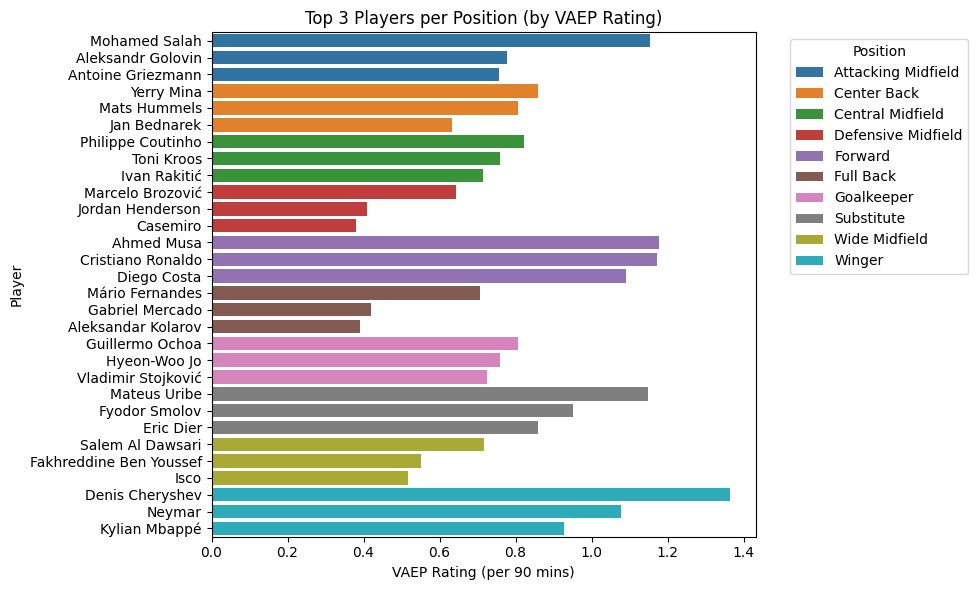

player_id              player_name  vaep_value  \
main_position                                                            
Attacking Midfield 75      3531.0            Mohamed Salah    2.502335   
                   143     5177.0        Aleksandr Golovin    3.675308   
                   265     5487.0        Antoine Griezmann    4.966191   
Center Back        525     6196.0               Yerry Mina    3.568975   
                   350     5572.0             Mats Hummels    1.755765   
                   129     4626.0             Jan Bednarek    1.708057   
Central Midfield   71      3501.0        Philippe Coutinho    4.178689   
                   352     5574.0               Toni Kroos    2.489702   
                   248     5470.0             Ivan Rakitić    5.493406   
Defensive Midfield 247     5469.0         Marcelo Brozović    3.556993   
                   76      3532.0         Jordan Henderson    2.319164   
                   317     5539.0                 Casemiro    1.474563   
Forward            251     5473.0               Ahmed Musa    2.929415   
                   172     5207.0        Cristiano Ronaldo    5.061574   
                   164     5198.0              Diego Costa    3.899987   
Full Back          136     5170.0          Mário Fernandes    3.977104   
                   495     5742.0          Gabriel Mercado    1.565763   
                   374     5596.0       Aleksandar Kolarov    1.258457   
Goalkeeper         355     5577.0          Guillermo Ochoa    3.424138   
                   396     5619.0             Hyeon-Woo Jo    2.478023   
                   379     5601.0       Vladimir Stojković    2.338557   
Substitute         522     6193.0             Mateus Uribe    2.579566   
                   160     5194.0            Fyodor Smolov    2.599757   
                   594    10956.0                Eric Dier    2.689435   
Wide Midfield      153     5187.0         Salem Al Dawsari    2.330155   
                   431     5654.0  Fakhreddine Ben Youssef    1.798818   
                   135     4926.0                     Isco    2.392291   
Winger             152     5186.0          Denis Cheryshev    4.804774   
                   122     4320.0                   Neymar    5.777044   
                   6       3009.0            Kylian Mbappé    5.754524   

                        offensive_value  defensive_value  count  \
main_position                                                     
Attacking Midfield 75          2.408846         0.093488    180   
                   143         2.477845         1.197462    440   
                   265         4.614089         0.352102    799   
Center Back        525         3.058366         0.510609    491   
                   350         1.059979         0.695786    315   
                   129         1.190255         0.517802    490   
Central Midfield   71          3.866855         0.311833   1048   
                   352         2.277944         0.211758    958   
                   248         4.163834         1.329572   1288   
Defensive Midfield 247         1.451155         2.105838   1058   
                   76          1.339761         0.979403    851   
                   317         0.946376         0.528187    776   
Forward            251         2.145168         0.784247    242   
                   172         4.781448         0.280125    460   
                   164         3.762958         0.137029    269   
Full Back          136         2.239240         1.737864    693   
                   495         1.052681         0.513082    527   
                   374         0.987777         0.270681    378   
Goalkeeper         355         0.025333         3.398805    233   
                   396         0.070041         2.407982    143   
                   379         0.024533         2.314025    166   
Substitute         522         1.695549         0.884017    292   
                   160         2.557407        

In [29]:
simplified_positions = {
	# GK
	"Goalkeeper": "Goalkeeper",

	# DEF
	"Left Back": "Full Back",
	"Right Back": "Full Back",
	"Left Wing Back": "Full Back",
	"Right Wing Back": "Full Back",
	"Left Center Back": "Center Back",
	"Right Center Back": "Center Back",
	"Center Back": "Center Back",

	# MID
	"Center Defensive Midfield": "Defensive Midfield",
	"Left Defensive Midfield": "Defensive Midfield",
	"Right Defensive Midfield": "Defensive Midfield",
	"Left Center Midfield": "Central Midfield",
	"Right Center Midfield": "Central Midfield",
	"Left Midfield": "Wide Midfield",
	"Right Midfield": "Wide Midfield",
	"Center Attacking Midfield": "Attacking Midfield",
	"Left Attacking Midfield": "Attacking Midfield",
	"Right Attacking Midfield": "Attacking Midfield",

	# FWD
	"Center Forward": "Forward",
	"Left Center Forward": "Forward",
	"Right Center Forward": "Forward",
	"Left Wing": "Winger",
	"Right Wing": "Winger",

	# Other
	"Substitute": "Substitute",
}


position_played = df_player_games.groupby("player_id").agg(
	minutes_played = ("minutes_played", "sum"),
	main_position = ("starting_position_name", lambda x: x.mode()[0])
).reset_index()

stats_pos = playersR.merge(position_played, how="left", on="player_id")
stats_pos = stats_pos[stats_pos.minutes_played > 180] # at least two full games played
stats_pos["main_position"] = stats_pos["main_position"].map(simplified_positions)
stats_pos = stats_pos[stats_pos["main_position"] != "Other"]
stats_pos["vaep_rating"] = stats_pos.vaep_value * 90 / stats_pos.minutes_played
stats_pos["offensive_rating"] = stats_pos.offensive_value * 90 / stats_pos.minutes_played
stats_pos["defensive_rating"] = stats_pos.defensive_value * 90 / stats_pos.minutes_played

# 포지션별 상위 3명 추출
top_players = (
	stats_pos.groupby("main_position")
	.apply(lambda x: x.nlargest(3, "vaep_rating"))
	.reset_index(drop=True)
)

plt.figure(figsize=(10, 6))
sns.barplot(
	data=top_players,
	y="player_name",
	x="vaep_rating",
	hue="main_position",
	dodge=False
)
plt.title("Top 3 Players per Position (by VAEP Rating)")
plt.xlabel("VAEP Rating (per 90 mins)")
plt.ylabel("Player")
plt.legend(title="Position", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

stats_pos.groupby("main_position").apply(
	lambda x: x.sort_values("vaep_rating", ascending=False).head(3)
)

### ATOMIC SPADL 데이터 시각화

- [matplotsoccer](https://github.com/TomDecroos/matplotsoccer/tree/master): 축구 이벤트/액션 데이터를 경기장 위에 시각화하는 라이브러리.

In [30]:
def nice_time(row):
	minute = int((row.period_id-1)*45 +row.time_seconds // 60)
	second = int(row.time_seconds % 60)
	return f"{minute}m{second}s"

def plot_actions(a: pd.DataFrame, g: pd.Series) -> None:
	home_team_name = df_teams[df_teams.team_id == g.home_team_id].team_name.values[0]
	away_team_name = df_teams[df_teams.team_id == g.away_team_id].team_name.values[0]

	minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
	game_info = f"{g.game_date} {home_team_name} {g.home_score}-{g.away_score} {away_team_name} {minute + 1}'"
	print(game_info)

	a["player_name"] = a.player_id.map(df_players.set_index("player_id").player_name)
	a["team_name"] = a.team_id.map(df_teams.set_index("team_id").team_name)
	a["type_name"] = a.type_id.map(atomicspadl.config.actiontypes_df().type_name.to_dict())
	#a["result_name"] = a.result_id.map(spadl.config.results_df().result_name.to_dict())
	a["nice_time"] = a.apply(nice_time, axis=1)

	a["end_x"] = a.x + a.dx
	a["end_y"] = a.y + a.dy

	if "vaep_value" in a.columns:
		for col in ["scores", "concedes", "offensive_value", "defensive_value", "vaep_value"]:
			a[col] = a[col].map(lambda x: f"{x:.3f}")

		labels = a[["nice_time", "type_name", "player_name", "team_name", "scores", "concedes", "vaep_value"]]
		labeltitle = ["time", "actiontype", "player", "team", "scores", "concedes", "vaep_value"]
	else:
		labels = a[["nice_time", "type_name", "player_name", "team_name"]]
		labeltitle = ["time", "actiontype", "player", "team"]

	mps.actions(
		location=a[["x", "y", "end_x", "end_y"]],
		action_type=a.type_name,
		team= a.team_name,
		#result= a.result_name == "success", # atomic spadl은 result_name 없음
		label=labels,
		labeltitle=labeltitle,
		zoom=False,
		figsize=6,
		color="green"
	)

2018-06-23 17:00:00 South Korea 1-2 Mexico 93'


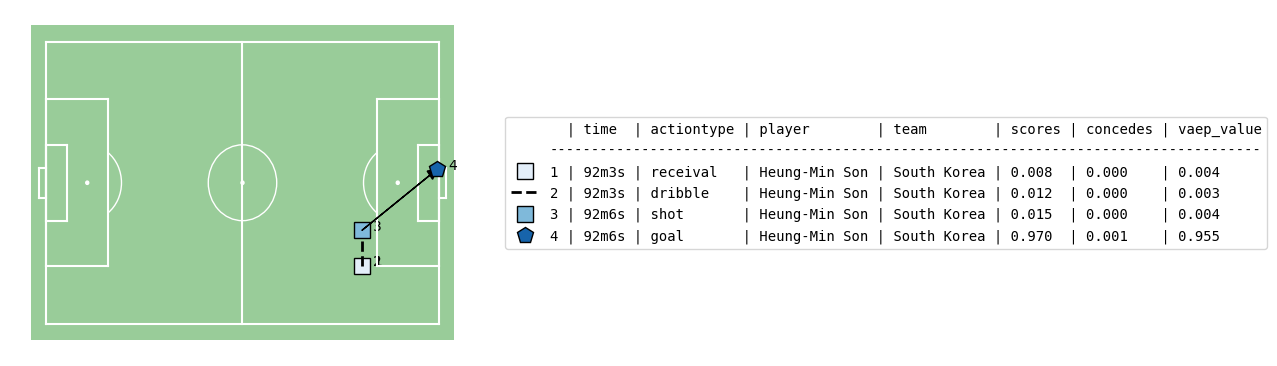

2018-06-27 16:00:00 South Korea 2-0 Germany 96'


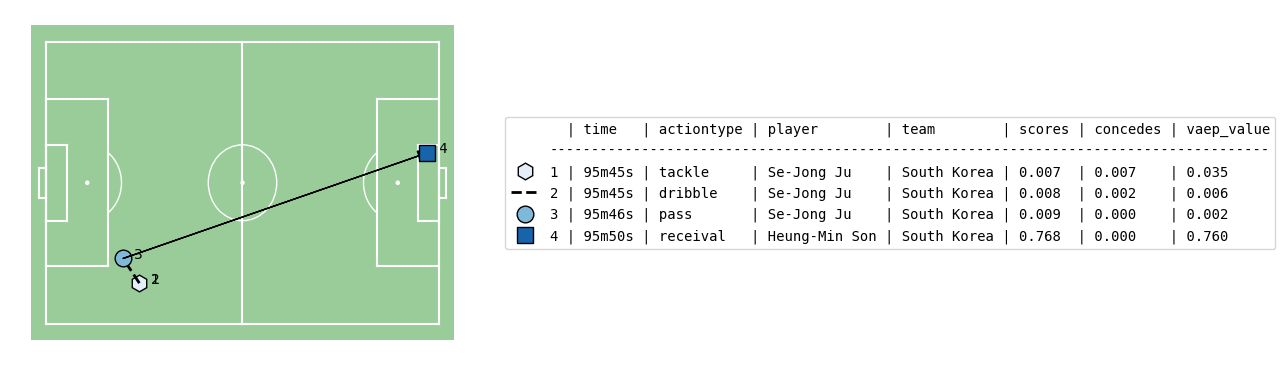

2018-06-27 16:00:00 South Korea 2-0 Germany 39'


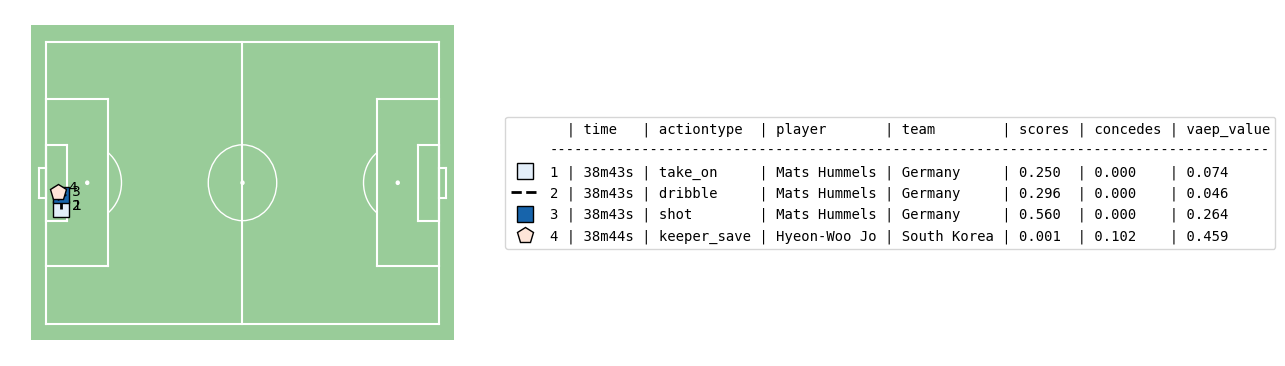

2018-06-27 16:00:00 South Korea 2-0 Germany 71'


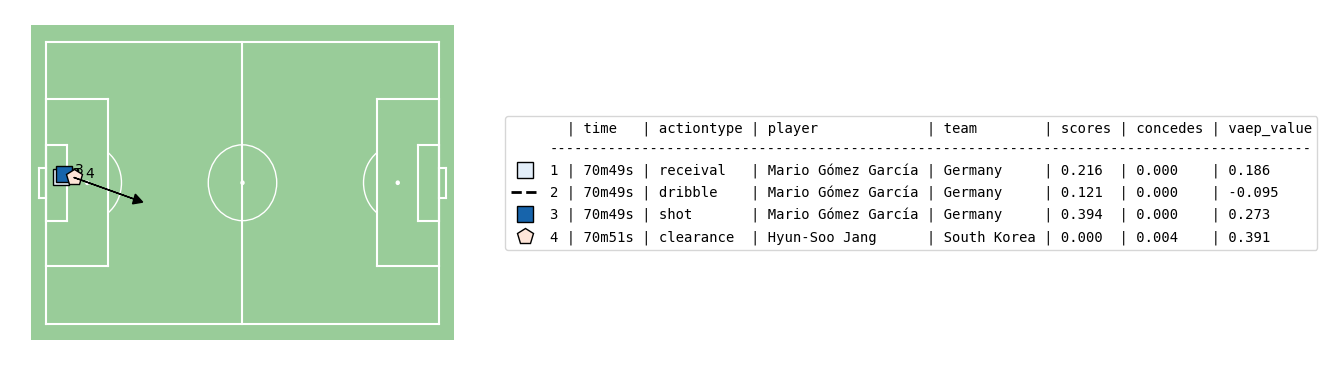

2018-06-27 16:00:00 South Korea 2-0 Germany 92'


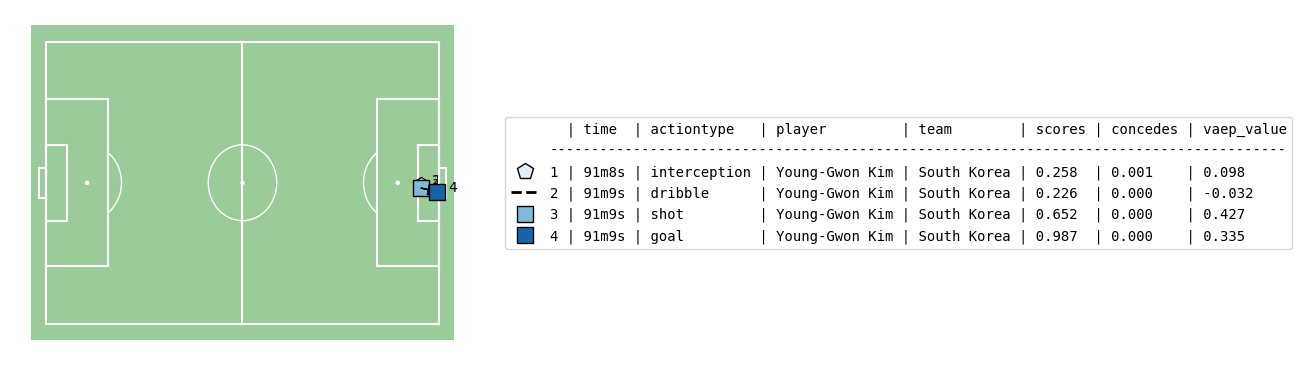

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,scores,concedes,type_name,bodypart_name,player_name,nickname,team_name,offensive_value,defensive_value,vaep_value,count,nice_time,end_x,end_y
117687,7567,f65a3d5b-b8d1-4ccd-b3d2-4ba0c732f5b7,2968,2,2768.5065,791,5604.0,100.1875,33.5750,0.000,0.0000,10,0,0.258,0.001,interception,foot,Young-Gwon Kim,Kim Young-Gwon,South Korea,0.098,0.000,0.098,1,91m8s,100.1875,33.5750
117688,7567,74044c2a-90d2-4d39-b801-8186dff67855,2969,2,2769.0530,791,5604.0,100.1875,33.5750,0.000,-0.8500,21,0,0.226,0.000,dribble,foot,Young-Gwon Kim,Kim Young-Gwon,South Korea,-0.032,0.000,-0.032,1,91m9s,100.1875,32.7250
117689,7567,2a8fbe84-ff7a-4bbf-87ca-3107fd6faf0c,2970,2,2769.5600,791,5604.0,100.1875,32.7250,4.375,-0.8925,11,4,0.652,0.000,shot,foot_left,Young-Gwon Kim,Kim Young-Gwon,South Korea,0.427,-0.000,0.427,1,91m9s,104.5625,31.8325
117690,7567,2a8fbe84-ff7a-4bbf-87ca-3107fd6faf0c,2971,2,2769.5600,791,5604.0,104.5625,31.8325,0.000,0.0000,26,4,0.987,0.000,goal,foot_left,Young-Gwon Kim,Kim Young-Gwon,South Korea,0.335,0.000,0.335,1,91m9s,104.5625,31.8325


In [82]:
sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "South Korea"] # view only actions from south korea
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id, time_seconds):
	m = int((period_id-1)*45 + time_seconds // 60)
	s = int(time_seconds % 60)
	return f"{m}m{s}s"

for j in range(0, 5):
	row = list(sorted_A[j:j+1].itertuples())[0]
	i = row.Index
	a = A[i - 3 : i+1].copy()
	g = list(test_games[test_games.game_id == a.game_id.values[0]].itertuples())[0]

	plot_actions(a, g)

a